In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import sklearn

import zipfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from helper_functions import *

import tensorflow as tf
import tensorflow_decision_forests as tfdf

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [3]:
full_data = pd.read_csv('cook_county_train.csv')
full_data.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 'Estimate (Land)', 
                'Estimate (Building)'
               ], axis=1, inplace=True)
train, valid = train_val_split(full_data)

train.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in train.columns
]
valid.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in train.columns
]
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label='Sale_Price', task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid, label = 'Sale_Price', task = tfdf.keras.Task.REGRESSION)

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
tf.get_logger().setLevel('FATAL')

# Create a Random Forest model with correct parameters
rf = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,
    verbose=0,
    # Remove the log_verbose_level parameter as it's not supported
)

# Compile with your metrics
rf.compile(metrics=['RootMeanSquaredError'])

# Train with verbose=0 to suppress output
rf.fit(train_ds, verbose=0)

I0000 00:00:1742706671.344699 11436552 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742706671.345730 11436552 kernel.cc:783] Collect training examples
I0000 00:00:1742706671.345736 11436552 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742706671.346361 11436552 kernel.cc:401] Number of batches: 164
I0000 00:00:1742706671.346366 11436552 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742706671.452503 11436552 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:65.9899 min:1 max:172 sd:28.9817
	1: "Age_Decade" NUMERICAL mean:6.59899 min:0.1 max:17.2 sd:2.8

In [6]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 3)

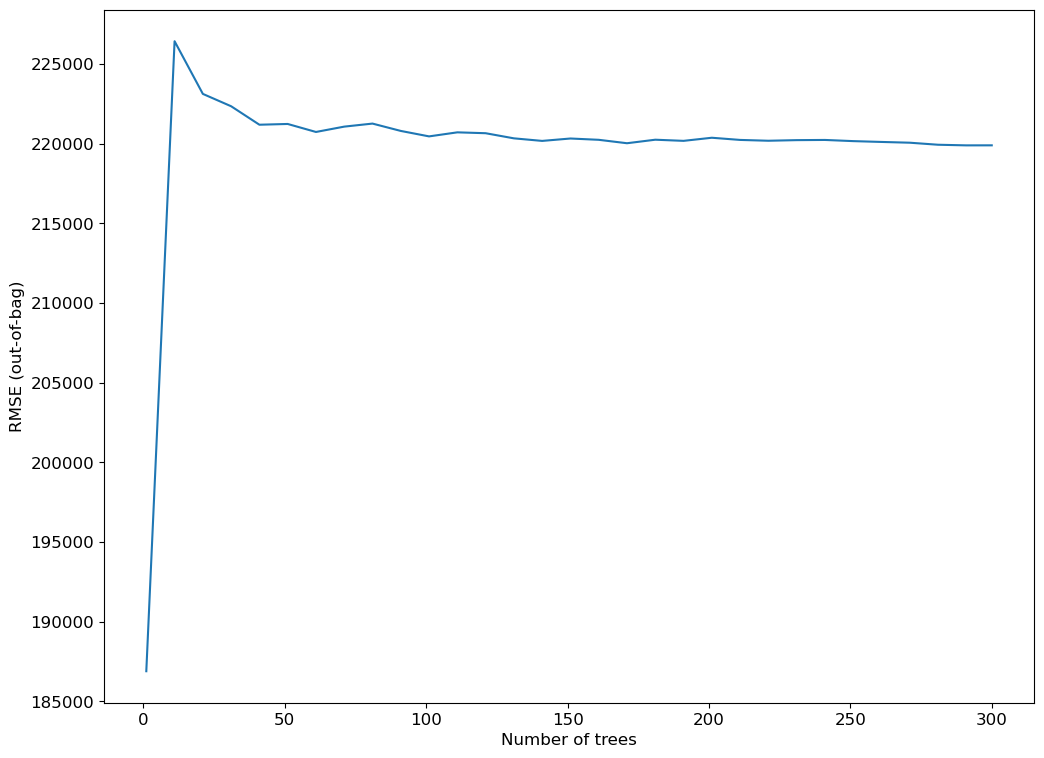

In [7]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [8]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=163833, accuracy=None, loss=None, rmse=219891.6577816648, ndcg=None, aucs=None, auuc=None, qini=None)

In [9]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

41/41 [==============================] - 4s 97ms/step - loss: 0.0000e+00 - root_mean_squared_error: 116396.1719
loss: 0.0000
root_mean_squared_error: 116396.1719


In [10]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE


In [11]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("Building_Square_Feet" (1; #7), 96.0),
 ("Property_Class" (1; #37), 77.0),
 ("Pure_Market_Filter" (1; #38), 43.0),
 ("Fireplaces" (1; #13), 40.0),
 ("Age" (1; #0), 17.0),
 ("Latitude" (1; #25), 15.0),
 ("Age_Decade" (1; #1), 8.0),
 ("Cathedral_Ceiling" (1; #8), 1.0),
 ("Census_Tract" (1; #9), 1.0),
 ("Central_Air" (1; #10), 1.0),
 ("Roof_Material" (1; #41), 1.0)]

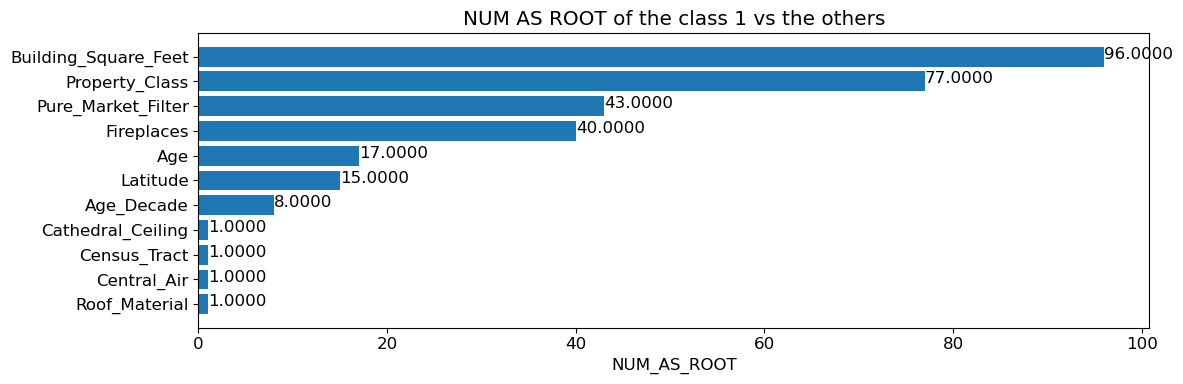

In [12]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()